# Aprendizaje, generalización y sobreajuste
## Validación cruzada (cross-validation)
#### Rodrigo Manzanas (rodrigo.manzanas@unican.es)
##### 18-Noviembre-2021

# 1 Introducción

Recordemos que una de las características básicas que ha de cumplir cualquier modelo estadístico que se entrene en un marco de aprendizaje supervisado es que tenga una buena **capacidad de generalización**, es decir, que arroje resultados razonablemente buenos cuando se aplique sobre datos que no han sido "vistos" durante la fase de entrenamiento (nuevos datos de test). En caso contario, diremos que el modelo está **sobreajustado** a la muestra de entrenamiento. 

En general, la introducción de grados de libertad/paramétros innecesarios acabará dando lugar a un modelo sobreajustado, por lo que suele ser conveniente partir de modelos simples e ir aumentando su complejidad si fuera necesario.

En esta práctica utilizaremos:

* Modelo de aprendizaje: Regresion lineal
* Dataset: *Auto* (paquete ISLR)
* Métrica de validación: Error cuadrático medio (RMSE)
* Paquetes de R: *ISRL*, *caret*

In [1]:
# cargo librerías 
library(ISLR)
library(caret)

Loading required package: lattice
Loading required package: ggplot2


# 2 Carga y transformación de datos

El dataset *Auto* (paquete `ISLR`) contiene información sobre las características de 392 vehículos. Cárgalo en tu sesión de `R` y échale un vistazo preliminar para familiarizarte con él.

In [2]:
data(Auto)
?Auto
str(Auto)
head(Auto, 10)
summary(Auto)

'data.frame':	392 obs. of  9 variables:
 $ mpg         : num  18 15 18 16 17 15 14 14 14 15 ...
 $ cylinders   : num  8 8 8 8 8 8 8 8 8 8 ...
 $ displacement: num  307 350 318 304 302 429 454 440 455 390 ...
 $ horsepower  : num  130 165 150 150 140 198 220 215 225 190 ...
 $ weight      : num  3504 3693 3436 3433 3449 ...
 $ acceleration: num  12 11.5 11 12 10.5 10 9 8.5 10 8.5 ...
 $ year        : num  70 70 70 70 70 70 70 70 70 70 ...
 $ origin      : num  1 1 1 1 1 1 1 1 1 1 ...
 $ name        : Factor w/ 304 levels "amc ambassador brougham",..: 49 36 231 14 161 141 54 223 241 2 ...


,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,18,8,307,130,3504,12.0,70,1,chevrolet chevelle malibu
2,15,8,350,165,3693,11.5,70,1,buick skylark 320
3,18,8,318,150,3436,11.0,70,1,plymouth satellite
4,16,8,304,150,3433,12.0,70,1,amc rebel sst
5,17,8,302,140,3449,10.5,70,1,ford torino
6,15,8,429,198,4341,10.0,70,1,ford galaxie 500
7,14,8,454,220,4354,9.0,70,1,chevrolet impala
8,14,8,440,215,4312,8.5,70,1,plymouth fury iii
9,14,8,455,225,4425,10.0,70,1,pontiac catalina


      mpg          cylinders      displacement     horsepower        weight    
 Min.   : 9.00   Min.   :3.000   Min.   : 68.0   Min.   : 46.0   Min.   :1613  
 1st Qu.:17.00   1st Qu.:4.000   1st Qu.:105.0   1st Qu.: 75.0   1st Qu.:2225  
 Median :22.75   Median :4.000   Median :151.0   Median : 93.5   Median :2804  
 Mean   :23.45   Mean   :5.472   Mean   :194.4   Mean   :104.5   Mean   :2978  
 3rd Qu.:29.00   3rd Qu.:8.000   3rd Qu.:275.8   3rd Qu.:126.0   3rd Qu.:3615  
 Max.   :46.60   Max.   :8.000   Max.   :455.0   Max.   :230.0   Max.   :5140  
                                                                               
  acceleration        year           origin                      name    
 Min.   : 8.00   Min.   :70.00   Min.   :1.000   amc matador       :  5  
 1st Qu.:13.78   1st Qu.:73.00   1st Qu.:1.000   ford pinto        :  5  
 Median :15.50   Median :76.00   Median :1.000   toyota corolla    :  5  
 Mean   :15.54   Mean   :75.98   Mean   :1.577   amc gremlin    

Para esta práctica sólo nos interesa la relación entre el peso (weight) y la potencia (horsepower). En concreto, nuestro objetivo será crear modelos de regresión que nos permitan predecir el peso en función de la potencia. 

Para trabajar más cómodamente, comienza por convertir las libras a kg (1libra = 0.453592kg). A continuación, haz un scatter plot de una variable frente a otra (puedes utilizar, por ejemplo, la función `pairs`). ¿Se puede extraer alguna conclusión a primera vista?

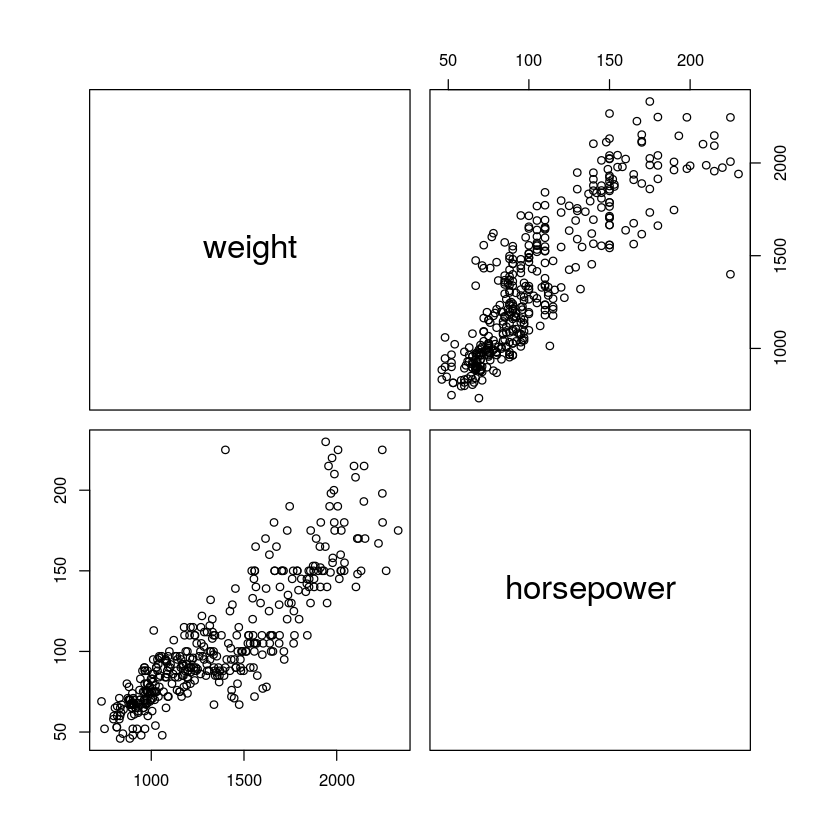

In [3]:
Auto$weight <- Auto$weight*0.453592  # conversión de libras a kg
pairs(weight ~ horsepower, data = Auto)  # scatter-plot

Comprueba, gráficamente, si una vez escogidas estas dos variables, podemos obtener alguna información útil extra a partir de la procedencia de los coches (origin). De nuevo, puedes utilizar la función `pairs`

[1] 1 3 2

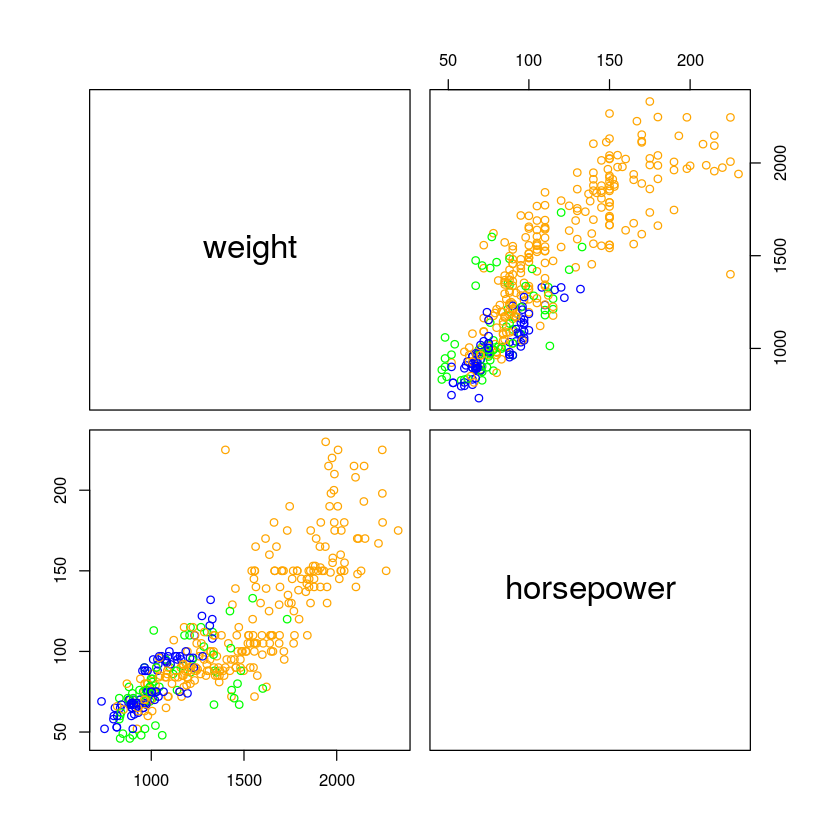

In [4]:
# doy un color distinto a cada origen
unique(Auto$origin)
pairs(weight ~ horsepower, data = Auto, 
      col = c("orange", "green", "blue")[Auto$origin])  # orange: American, green: European, blue: Japanese

Para trabajar más cómodamente será conveniente renombrar los niveles de la variable origin. Utiliza, por ejemplo, las etiquetas "European", "American" y "Japanese". Puedes apoyarte para ello en las funciones `factor` y `as.character`.

In [5]:
# renombro los niveles de la variable origin 
Auto$origin <- as.character(factor(Auto$origin, 
                                   labels = c("American", "European", "Japanese")))
print(Auto$origin)
class(Auto$origin)

  [1] "American" "American" "American" "American" "American" "American"
  [7] "American" "American" "American" "American" "American" "American"
 [13] "American" "American" "Japanese" "American" "American" "American"
 [19] "Japanese" "European" "European" "European" "European" "European"
 [25] "American" "American" "American" "American" "American" "Japanese"
 [31] "American" "Japanese" "American" "American" "American" "American"
 [37] "American" "American" "American" "American" "American" "American"
 [43] "American" "American" "American" "American" "American" "American"
 [49] "American" "European" "European" "European" "Japanese" "Japanese"
 [55] "European" "American" "Japanese" "American" "European" "American"
 [61] "American" "American" "American" "American" "American" "American"
 [67] "American" "American" "American" "American" "Japanese" "American"
 [73] "American" "American" "American" "European" "European" "European"
 [79] "European" "American" "Japanese" "Japanese" "American" "Ja

[1] "character"

En la parte final de la práctica trabajaremos por separado con los coches europeos, americanos y japoneses. Crea por tanto un subconjunto de datos independiente para cada origen.

In [6]:
# coches europeos
europe <- Auto[Auto$origin == "European", ]
str(europe)
# coches americanos
america <- Auto[Auto$origin == "American", ]
str(america)
# coches japoneses
japan <- Auto[Auto$origin == "Japanese", ]
str(japan)

'data.frame':	68 obs. of  9 variables:
 $ mpg         : num  26 25 24 25 26 28 30 30 27 23 ...
 $ cylinders   : num  4 4 4 4 4 4 4 4 4 4 ...
 $ displacement: num  97 110 107 104 121 116 79 88 97 97 ...
 $ horsepower  : num  46 87 90 95 113 90 70 76 60 54 ...
 $ weight      : num  832 1212 1102 1077 1013 ...
 $ acceleration: num  20.5 17.5 14.5 17.5 12.5 14 19.5 14.5 19 23.5 ...
 $ year        : num  70 70 70 70 70 71 71 71 71 72 ...
 $ origin      : chr  "European" "European" "European" "European" ...
 $ name        : Factor w/ 304 levels "amc ambassador brougham",..: 282 211 16 258 22 208 210 123 286 293 ...
'data.frame':	245 obs. of  9 variables:
 $ mpg         : num  18 15 18 16 17 15 14 14 14 15 ...
 $ cylinders   : num  8 8 8 8 8 8 8 8 8 8 ...
 $ displacement: num  307 350 318 304 302 429 454 440 455 390 ...
 $ horsepower  : num  130 165 150 150 140 198 220 215 225 190 ...
 $ weight      : num  1589 1675 1559 1557 1564 ...
 $ acceleration: num  12 11.5 11 12 10.5 10 9 8.5 10 8.5 .

Dibuja, en una misma figura, un scatter plot "peso frente a potencia" para los coches europeos.

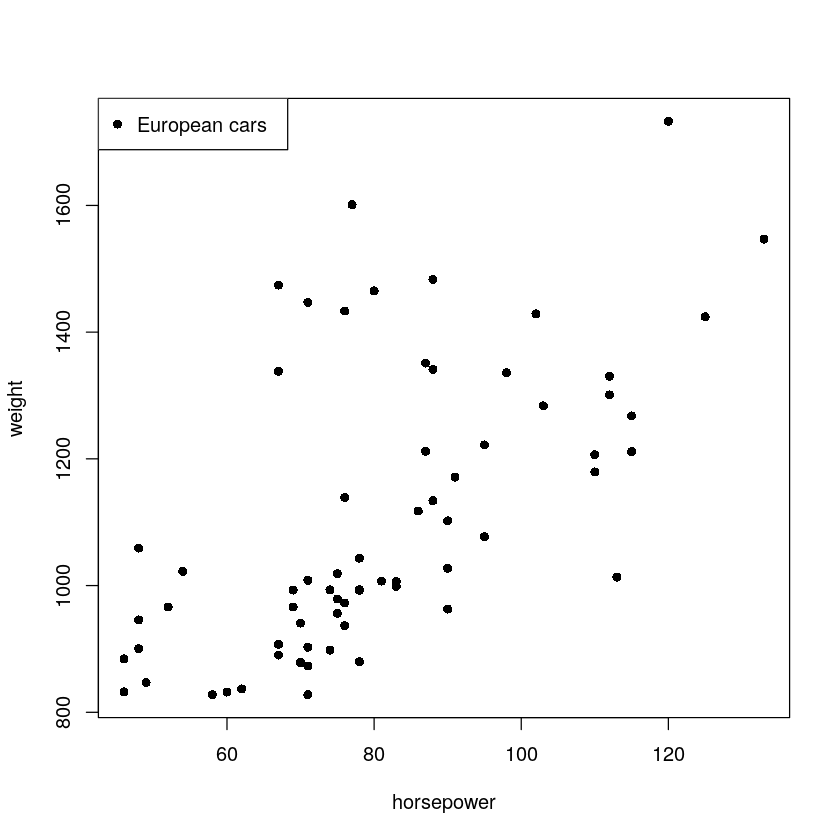

In [7]:
# scatter plot coches europeos
plot(europe$horsepower, europe$weight, 
     xlab = "horsepower", ylab = "weight",
     pch = 16, col = "black",
     xlim = range(europe$horsepower))
legend("topleft", "European cars", 
       pch = 16, col = "black")

# 3 Definición de la métrica de validación

A continuación definimos la métrica de validación que vamos a emplear para determinar el error de nuestros modelos de regresión, el error cuadrático medio (*root mean square error*, RMSE).

In [8]:
# métrica de validación: RMSE
rmse <- function(obs, pred) {  
  sqrt(mean((obs - pred)^2))
}

# 4 Construcción del modelo y evaluación

## 4.1 Construcción del modelo sin cross-validación

Como hemos dicho, trabajaremos en esta práctica con un modelo lineal (una simple regresión). Utiliza la función `lm` (paquete `stats`) para encontrar los coeficientes de una regresión lineal del tipo $peso = peso(potencia)$ en el dataset de coches europeos. A continuación, dibuja en la misma figura la nube de puntos del dataset y la recta de ajuste que acabas de obtener. Utiliza para ello la función `abline`.

In [9]:
# regresión lineal
reg <- lm(weight ~ horsepower, data = europe)  
summary(reg)


Call:
lm(formula = weight ~ horsepower, data = europe)

Residuals:
    Min      1Q  Median      3Q     Max 
-310.06 -122.05  -45.37   62.89  521.47 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  558.528     89.459   6.243 3.50e-08 ***
horsepower     6.769      1.078   6.280 3.01e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 177.8 on 66 degrees of freedom
Multiple R-squared:  0.3741,	Adjusted R-squared:  0.3646 
F-statistic: 39.44 on 1 and 66 DF,  p-value: 3.014e-08


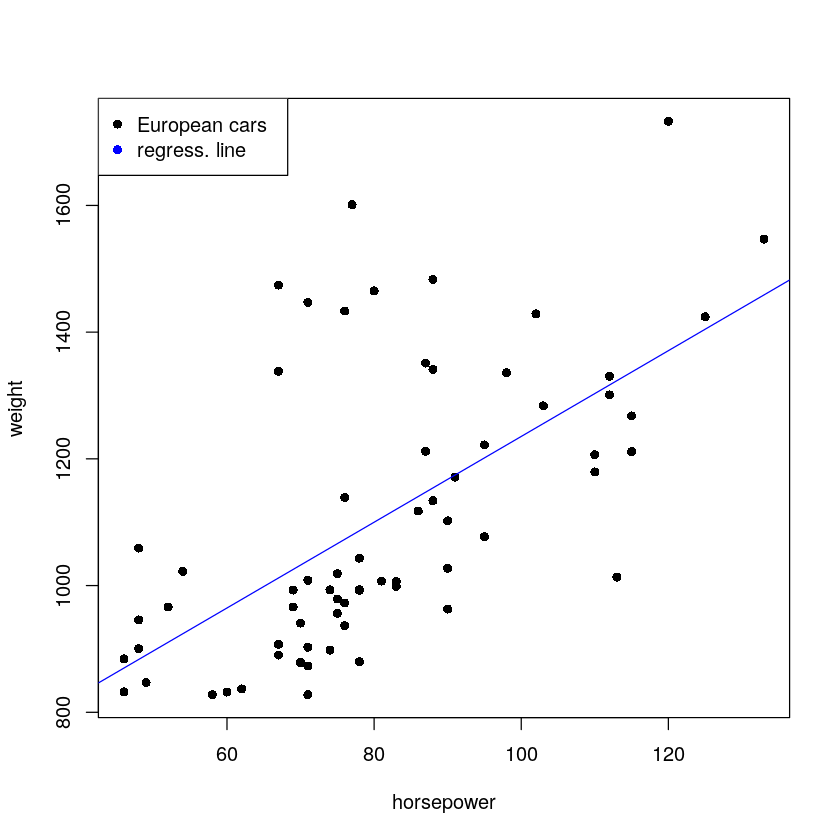

In [10]:
plot(europe$horsepower, europe$weight, 
     xlab = "horsepower", ylab = "weight",
     pch = 16, col = "black",
     xlim = range(europe$horsepower))
abline(reg, col = "blue")
legend("topleft", c("European cars", "regress. line"), 
       pch = 16, col = c("black", "blue"))

A continuación, compara los valores estimados según esta regresión ("fitted values") con los valores reales. Para ello, dibuja en una misma figura, y en orden secuencial, ambos conjuntos de valores y calcula el RMSE.

[1] 175.19

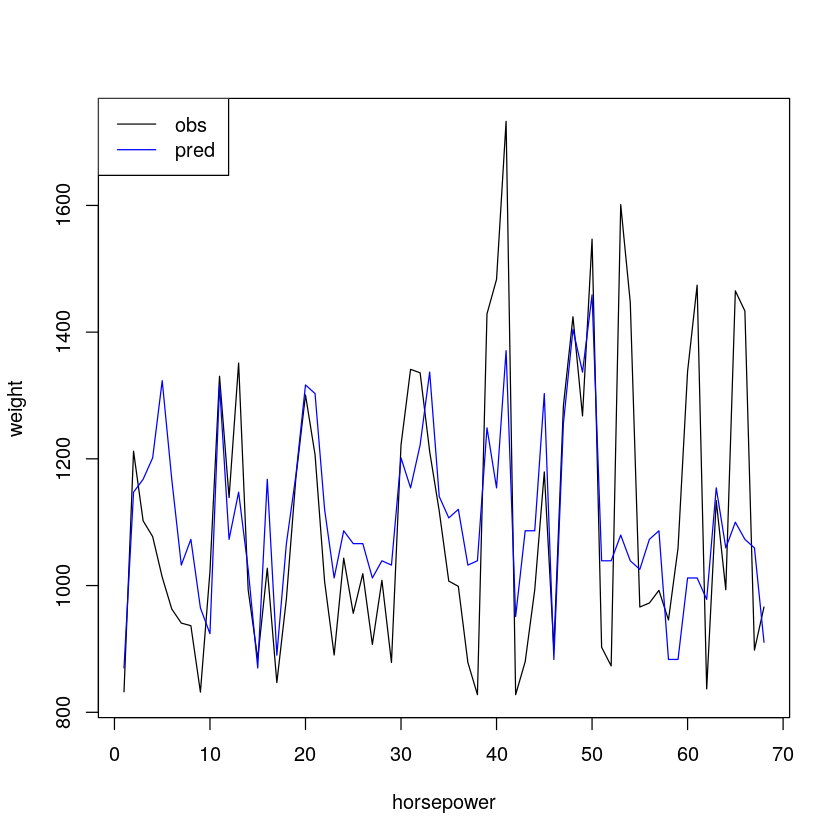

In [11]:
ypred <- reg$fitted.values  # valores predichos por el modelo lineal

plot(europe$weight, type = "l", col = "black",
    xlab = "horsepower", ylab = "weight")  # valores reales 
lines(ypred, col = "blue")  # predicciones
legend("topleft", c("obs","pred"), lty = 1, 
       col = c("black", "blue"))

rmse(obs = europe$weight, pred = ypred)  # RMSE

**Nota**: Fíjate que los valores contenidos en la variable `ypred` son exactamente los mismos que habríamos obtenido utilizando la función `predict` para predecir a partir del modelo entrenado (`reg`).

In [12]:
?predict
ypred2 <- predict(object = reg,  # uso de la función 'predict'
                 newdata = data.frame(horsepower = europe$horsepower))
max(ypred - ypred2)

[1] 5.115908e-12

En este primer ejemplo hemos utilizado como conjunto de validación el mismo sobre el que habíamos entrenado el modelo. Por tanto, no podemos estimar su capacidad de generalización.

Si la validación se realiza sobre un subconjunto independiente de la muestra utilizada para el entrenamiento (es decir, en modo cross-validación), el error cometido será mayor. Sin embargo, esta metodología nos permitirá estimar la capacidad de generalización del método. A continuación, vamos a ilustrar esto con distintos ejemplos.

## 4.2 Construcción del modelo usando cross-validación *hold-out* 

El método de cross-validación más básico es el *hold-out*, en el que la muestra total se divide en dos subconjuntos independientes, uno para training y otro para validación. 

---

**Ejercicio**

Para este primer ejemplo vamos a dividir los coches europeos en dos subconjuntos de igual tamaño, con la particularidad de que el primero (segundo) de esos subconjuntos contendrá la mitad de coches con potencias menores (mayores). Utiliza los coches de menor potencia para entrenar una regresión lineal y utiliza el modelo que obtengas para predecir el peso de los coches con 1) potencias menores (propio conjunto de training) y 2) potencias mayores. Calcula el RMSE en ambos casos. ¿Qué conclusión obtienes? 

In [13]:
n <- nrow(europe)  # número de datos en el dataset de coches europeos
ind <- order(europe$horsepower)[1:ceiling(n/2)]  # índices que identifican la mitad de coches con potencias menores
europe.train <- europe[ind, ]  # mitad de coches menos potentes: training
europe.val <- europe[-ind,]  # mitad de coches más potentes: validation 
dim(europe.train)
dim(europe.val)
mean(europe.train$horsepower)
mean(europe.val$horsepower)

[1] 34  9

[1] 34  9

[1] 65.26471

[1] 95.85294

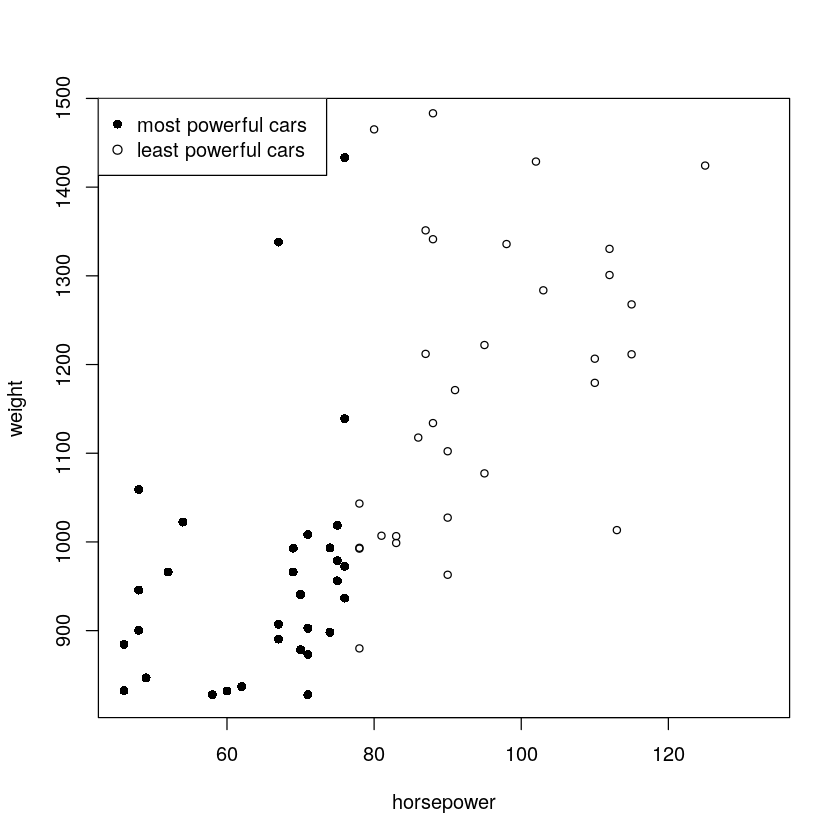

In [14]:
# plots
plot(europe.train$horsepower, europe.train$weight,  # coches europeos menos potentes (muestra de train)
     xlab = "horsepower", ylab = "weight",
     pch = 16, col = "black",
     xlim = range(europe$horsepower))
points(europe.val$horsepower, europe.val$weight, 
       pch = 21, cex = 0.8)  # coches europeos más potentes (muestra de validación)
legend("topleft", c("most powerful cars","least powerful cars"), 
       pch = c(16, 21), 
       col = c("black", "black"))

In [15]:
# construyo el modelo de regresión lineal (entreno con los coches menos potentes)
reg0 <- lm(weight ~ horsepower, data = europe.train) 

# predicción sobre el propio conjunto de train
ypred0.train <- predict(reg0, 
                       newdata = data.frame(horsepower = europe.train$horsepower))  
rmse(europe.train$weight, ypred0.train)

# predicción sobre el conjunto reservado para validación 
ypred0.val <- predict(reg0, 
                     newdata = data.frame(horsepower = europe.val$horsepower))  
rmse(europe.val$weight, ypred0.val)

[1] 168.2733

[1] 201.7902

### 4.2.1 Muestreo aleatorio para obtener las muestras de train y de validación

Lógicamente, los resultados sobre el conjunto de validación en el ejercicio anterior son malos porque la muestra que hemos utilizado para el entrenamiento no es representativa de la población (y en particular, de la muestra de validación). Para tratar de minimizar este tipo de problema, una solución es aleatorizar la selección train/validación. 

---

**Ejercicio**

Vuelve a realizar el mismo ejercicio pero escogiendo aleatoriamente la mitad del dataset para training y la otra mitad para validación (utiliza la función `sample` para ello). ¿Cómo han cambiado los resultados? En este caso, ¿dirías que el modelo que has construido está sobreajustado?

In [16]:
set.seed(10)  # fijo semilla (para asegurar la reproducibilidad)
ind <- sample(1:n, ceiling(n/2))  # índices aleatorios para training (mitad del dataset)
europe.train <- europe[ind, ]  # training
europe.val <- europe[-ind,]  # validation
dim(europe.train)
dim(europe.val)
mean(europe.train$horsepower)
mean(europe.val$horsepower)

[1] 34  9

[1] 34  9

[1] 77.35294

[1] 83.76471

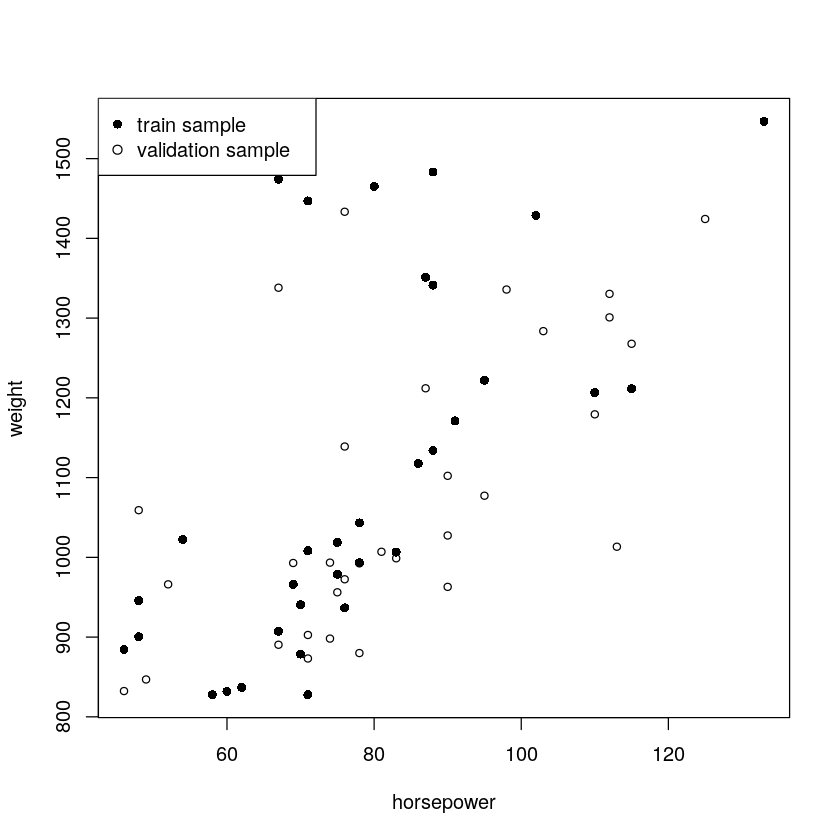

In [17]:
# plots
plot(europe.train$horsepower, europe.train$weight,  # coches europeos utilizados para training
     xlab = "horsepower", ylab = "weight",
     pch = 16, col = "black",
     xlim = range(europe$horsepower))
points(europe.val$horsepower, europe.val$weight, 
       pch = 21, cex = 0.8)  # coches europeos reservados para validation
legend("topleft", c("train sample","validation sample"), 
       pch = c(16, 21), 
       col = c("black", "black"))

In [18]:
# construyo el modelo de regresión lineal
reg1 <- lm(weight ~ horsepower, data = europe.train)  

# predicciones sobre el conjunto de training
ypred1.train <- predict(reg1, 
                       newdata = data.frame(horsepower = europe.train$horsepower))
rmse(europe.train$weight, ypred1.train)

# predicciones sobre el conjunto de validación
ypred1.val <- predict(reg1, 
                     newdata = data.frame(horsepower = europe.val$horsepower))
rmse(europe.val$weight, ypred1.val)

[1] 170.2045

[1] 182.9423

Aún así, la metodología *hold-out* tiene dos limitaciones importantes. Por un lado, como acabamos de comprobar, la estimación del error en el conjunto de validación puede variar mucho en función de la partición considerada.

---

**Ejercicio**

Repite el ejercicio anterior (cross-validation hold-out) para 20 particiones aleatorias train/validation distintas (para ello, programa un bucle). ¿Cómo se distribuyen los errores (RMSE) sobre la muestra de validación?

RMSE partition 1 = 166.153910849437
RMSE partition 2 = 166.939474338058
RMSE partition 3 = 180.036701916579
RMSE partition 4 = 187.477799811193
RMSE partition 5 = 157.019265629075
RMSE partition 6 = 181.257187789659
RMSE partition 7 = 203.368093835323
RMSE partition 8 = 176.357344842787
RMSE partition 9 = 159.272971699248
RMSE partition 10 = 175.469107993703
RMSE partition 11 = 210.53268830985
RMSE partition 12 = 184.135975547397
RMSE partition 13 = 145.252428018493
RMSE partition 14 = 163.372175204985
RMSE partition 15 = 181.495427415775
RMSE partition 16 = 223.539245883026
RMSE partition 17 = 157.480524924982
RMSE partition 18 = 173.047526328605
RMSE partition 19 = 178.705513878046
RMSE partition 20 = 176.259475855796


[1] 177.35864  18.80664

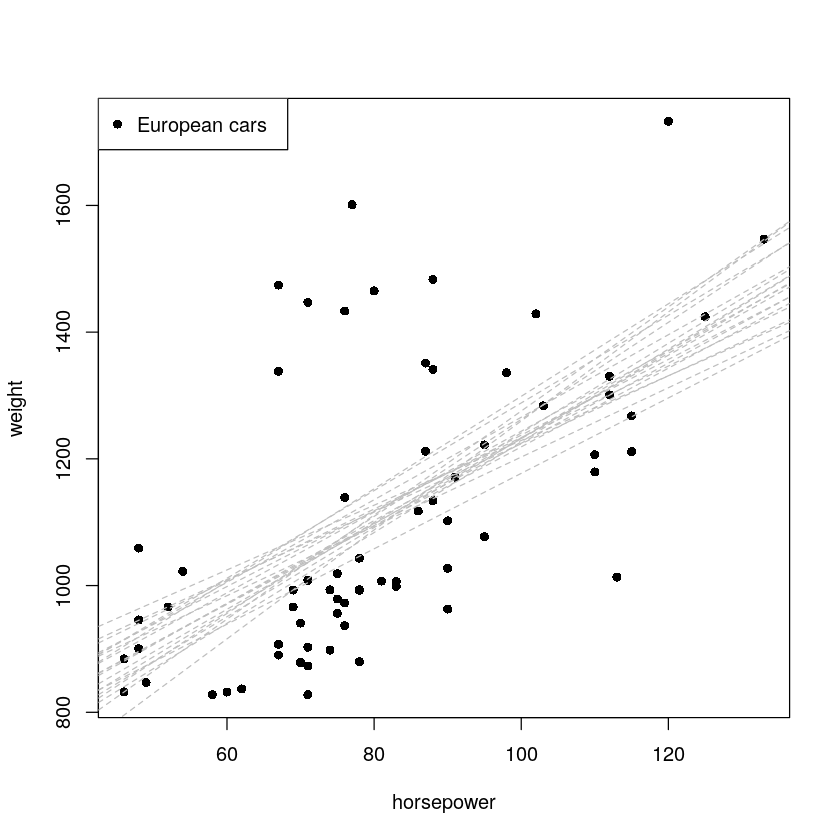

In [19]:
# scatter plot 
plot(europe$horsepower, europe$weight,  # coches europeos
     xlab = "horsepower", ylab = "weight",
     pch = 16, col = "black",
     xlim = range(europe$horsepower))
legend("topleft", "European cars", pch = 16, col = "black")

rmse.ho = c()  # vector vacío que iré rellenando en el bucle
for (i in 1:20) {  # bucle que recorre 20 particiones train/validation distintas
  ind <- sample(1:n, ceiling(n/2))  # partición en mitades aleatorias
  
  europe.train.i <- europe[ind, ]  # mitad (aleatoria) para training
  europe.val.i <- europe[-ind, ]  # mitad (aleatoria) para validation
    
  # construyo reg. lineal
  reg.i <- lm(weight ~ horsepower, data = europe.train.i)  
  
  # predigo sobre el conjunto reservado para validación 
  ypred.val.i <- predict(reg.i, data.frame(horsepower = europe.val.i$horsepower))  
  abline(reg.i, lty = 2, col = "grey")
  
  # valido
  rmse.ho[i] = rmse(europe.val.i$weight, ypred.val.i) 
    
  # error de validación
  message("RMSE partition ", i, " = ", rmse(europe.val.i$weight, ypred.val.i))
}
c(mean(rmse.ho), sd(rmse.ho))  # variabilidad error de validación

Por otro lado, en conjuntos de datos pequeños como el de este ejemplo (n/2 < 40), la cross-validación hold-out puede dar lugar a una sobrestimación del error de validación (cualquier método estadístico tiende a proporcionar peores resultados cuando se trabaja con pocos datos).

Los métodos de cross-validación *leave-one-out* y *k-fold* surgen para aliviar estos dos problemas. 

## 4.3 Construcción del modelo usando cross-validación *leave-one-out*

Las características del método de cross-validación leave-one-out son las siguientes:

* La selección de la muestra de entrenamiento NO se hace aleatoriamente, eliminando la variabilidad del error de validación.

* La muestra de entrenamiento es la mayor posible: Si un conjunto de datos tiene `n` registros, el ajuste del modelo se realiza con `n - 1` datos y el único dato restante  se utiliza para validación. La operación se repite `n` veces.

**Ejercicio**

Aplica el método de cross-validación leave-one-out para predecir, usando un modelo lineal que use como único predictor la potencia, el peso de los coches europeos (construye un bucle para ello). ¿Qué error de validación (RMSE) "global" (es decir, sobre la muestra completa) obtienes?

In [20]:
ypred.2 <- c()  # inicializo vector vacío

for (i in 1:nrow(europe)) {  # recorro todos los elemento del dataset
  message("... partition ", i, " out of ", nrow(europe), " ...")
    
  # construyo la reg. lineal con n-1 datos
  reg.i <- lm(weight~horsepower, data = europe, subset = -i)
    
  # doy una predicción para el único dato que no he utilizado en el entrenamiento  
  ypred.2[i] <- predict(reg.i, data.frame(horsepower = europe$horsepower[i]))
}
rmse(europe$weight, ypred.2)  # RMSE

... partition 1 out of 68 ...
... partition 2 out of 68 ...
... partition 3 out of 68 ...
... partition 4 out of 68 ...
... partition 5 out of 68 ...
... partition 6 out of 68 ...
... partition 7 out of 68 ...
... partition 8 out of 68 ...
... partition 9 out of 68 ...
... partition 10 out of 68 ...
... partition 11 out of 68 ...
... partition 12 out of 68 ...
... partition 13 out of 68 ...
... partition 14 out of 68 ...
... partition 15 out of 68 ...
... partition 16 out of 68 ...
... partition 17 out of 68 ...
... partition 18 out of 68 ...
... partition 19 out of 68 ...
... partition 20 out of 68 ...
... partition 21 out of 68 ...
... partition 22 out of 68 ...
... partition 23 out of 68 ...
... partition 24 out of 68 ...
... partition 25 out of 68 ...
... partition 26 out of 68 ...
... partition 27 out of 68 ...
... partition 28 out of 68 ...
... partition 29 out of 68 ...
... partition 30 out of 68 ...
... partition 31 out of 68 ...
... partition 32 out of 68 ...
... partition 33 

[1] 179.7766

**Ejercicio**

Repite el ejercicio anterior pero usando el paquete *caret*.

In [21]:
# http://topepo.github.io/caret/index.html
ctrl <- trainControl(method = "LOOCV")  # leave-one-out CV
mod <- train(weight ~ horsepower,  # 'train': función clave de 'caret'
               data = europe,
               method = "lm",
               trControl = ctrl)
summary(mod)


Call:
lm(formula = .outcome ~ ., data = dat)

Residuals:
    Min      1Q  Median      3Q     Max 
-310.06 -122.05  -45.37   62.89  521.47 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  558.528     89.459   6.243 3.50e-08 ***
horsepower     6.769      1.078   6.280 3.01e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 177.8 on 66 degrees of freedom
Multiple R-squared:  0.3741,	Adjusted R-squared:  0.3646 
F-statistic: 39.44 on 1 and 66 DF,  p-value: 3.014e-08


In [22]:
mod$results$RMSE

[1] 179.7766

## 4.4 Construcción del modelo usando cross-validación *k-fold*

Si el tamaño muestral es grande, el método leave-one-out se vuelve muy costoso desde el punto de vista computacional. Para evitar este coste surge otro método de validación cruzada, llamado **k-fold**, en el que se hace un leave-one-out por "bloques" o "folds": 

* Se divide la muestra en `k` subconjuntos.

* Se ajustan `k` modelos, considerando en cada caso un bloque como conjunto de validación y los `k-1` restantes para el entrenamiento. 

* La estimación del error dependerá de cómo se realice la partición de los datos, es decir, de cómo se seleccionen los folds. Aún así, con un número suficiente de folds, se obtendrían las mismas conclusiones que con leave-one-out. 

**Ejercicio**

1) Parte el dataset de coches europeos en `k=10` subconjuntos, todos ellos con el mismo número de datos, seleccionados aleatoriamente (utiliza las funciones `sample` y `split` para ello).

In [23]:
k <- 10  # número de folds
set.seed(10)  # fijo semilla para asegurar reproducibilidad

# creo un vector con los indices que identifican las posiciones que corresponden a cada fold
split.factor <- sample(rep(1:10, each = ceiling(n/k)), n)   

# creo una lista cuyos elementos son cada uno los 10 folds
spl.europe <- split(europe, f = split.factor)
str(spl.europe)

List of 10
 $ 1 :'data.frame':	6 obs. of  9 variables:
  ..$ mpg         : num [1:6] 30 25 20 41.5 43.4 30.7
  ..$ cylinders   : num [1:6] 4 4 4 4 4 6
  ..$ displacement: num [1:6] 88 121 130 98 90 145
  ..$ horsepower  : num [1:6] 76 115 102 76 48 76
  ..$ weight      : num [1:6] 937 1212 1429 973 1059 ...
  ..$ acceleration: num [1:6] 14.5 13.5 15.7 14.7 23.7 19.6
  ..$ year        : num [1:6] 71 75 76 80 80 81
  ..$ origin      : chr [1:6] "European" "European" "European" "European" ...
  ..$ name        : Factor w/ 304 levels "amc ambassador brougham",..: 123 260 297 302 300 299
 $ 2 :'data.frame':	7 obs. of  9 variables:
  ..$ mpg         : num [1:7] 26 27 22 26 29 30.5 30
  ..$ cylinders   : num [1:7] 4 4 4 4 4 4 4
  ..$ displacement: num [1:7] 97 97 121 96 90 97 146
  ..$ horsepower  : num [1:7] 46 60 76 69 70 78 67
  ..$ weight      : num [1:7] 832 832 1139 993 879 ...
  ..$ acceleration: num [1:7] 20.5 19 18 18 14.2 14.1 21.8
  ..$ year        : num [1:7] 70 71 72 72 76 77 80


2) Utiliza `k-1` folds para entrenar un modelo lineal y predice sobre el fold restante. Para concatenar folds, utiliza la función `do.call` (que permite operar sobre listas como si fueran matrices/vectores) llamando a `rbind`. Repite esta operación `k` veces (utiliza un bucle `lapply`).

In [24]:
ypred.3 <- lapply(1:k, function(x) {  # bucle lapply que recorre los 10 folds
  # construyo reg. lineal con k-1 folds
  reg.3 <- lm(weight ~ horsepower, data = do.call("rbind", spl.europe[-x]))
    
  # predigo sobre el fold restante
  predict(reg.3, data.frame(horsepower = spl.europe[[x]]$horsepower))
})

3) Dibuja, en un mismo gráfico, los pesos reales y los predichos en modo 10-fold. De nuevo, recurre a la función `do.call` (llamando a `c`) para concatenar las predicciones.

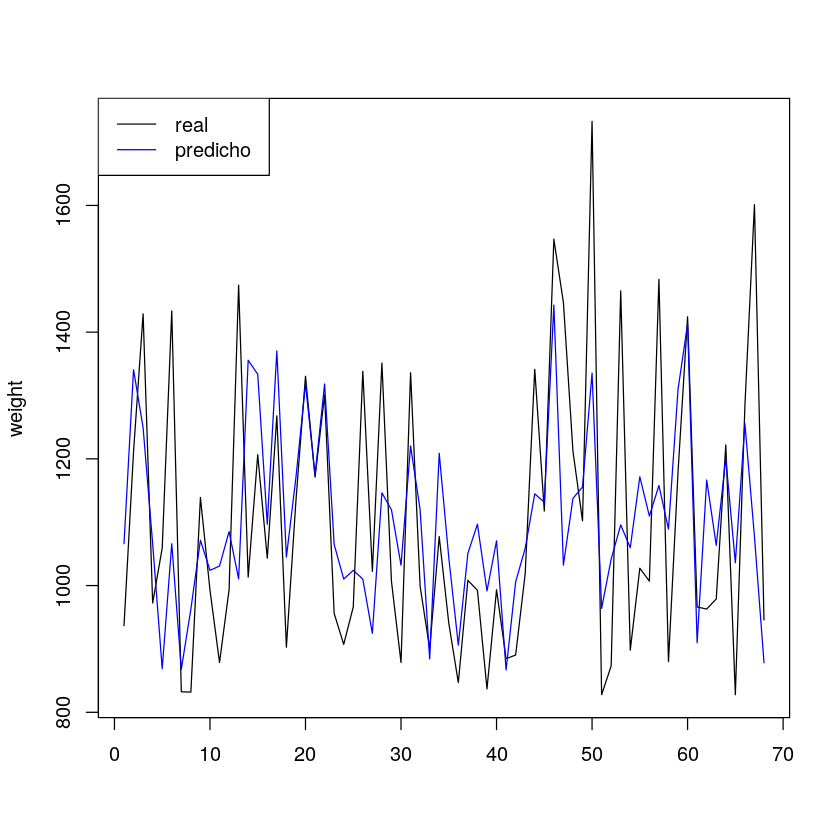

In [25]:
plot(do.call("rbind", spl.europe)$weight, type = "l",
    xlab = "", ylab = "weight", col = "black")  # pesos reales
lines(do.call("c", ypred.3), col = "blue")  # pesos predichos
legend("topleft", c("real", "predicho"), lty = 1, 
       col = c("black", "blue"))

4) Calcula el error "global" cometido sobre todo el dataset (tendrás que concatenar las 10 predicciones). ¿Qué conclusión obtienes?

In [26]:
# error "global" cometido sobre todo el dataset
rmse(do.call("rbind", spl.europe)$weight, do.call("c", ypred.3))               

[1] 179.6389

# Tarea 1

¿Es el modelo aprendido con los registros europeos adecuado para estimar el peso de los coches americanos? En otras palabras, ¿qué ocurre cuando aplicamos el modelo entrenado con la muestra `europe` para predecir sobre la muestra de test `america`? Utiliza las funciones de visualización que hemos visto (`plot`, `points`, `lines`, `abline`, ...) para ilustrar los resultados.

In [27]:
# construyo reg. lineal con datos de coches europeos
reg.3.all <- lm(weight ~ horsepower, data = europe)

# predigo sobre los coches americanos (muestra de test)
ypred.test.3 <- predict(reg.3.all, 
                       newdata = data.frame(horsepower = america$horsepower))
rmse(america$weight, ypred.test.3) # error de test

[1] 258.6562

Ya vimos para los coches europeos que el error (RMSE) que obteníamos en modo cross-validación era bastante similar al obtenido sin cross-validación, por lo que la capacidad de generalización del modelo es buena para los coches europeos. Sin embargo, este modelo no es adecuado para predecir el peso de los coches americanos, ya que la diferencia entre el error de validación y el de test es muy alta. ¿A qué crees que se debe?

# Tarea 2

Repite el ejemplo en el que hemos utilizado una cross-validación 10-fold para el dataset de coches europeos, pero con *caret*. Obtén el error (RMSE) de validación global. Tendrás que investigar cómo utilizar la función `trainControl`.

In [28]:
ctrl <- trainControl(method = "cv", number = 10)
mod <- train(weight ~ horsepower,
               data = europe,
               method = "lm",
               trControl = ctrl,
               metric = "RMSE")
mod

Linear Regression 

68 samples
 1 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 61, 64, 63, 60, 62, 60, ... 
Resampling results:

  RMSE      Rsquared   MAE     
  174.0042  0.4051061  137.0545

Tuning parameter 'intercept' was held constant at a value of TRUE

# Tarea 3

Utiliza los datos de los coches americanos para estimar los pesos de los coches europeos por un lado y los de los japoneses por otro (puedes emplear el paquete `caret` si quieres). ¿Son buenos los resultados que obtienes? 

In [29]:
# entreno el modelo sobre los coches americanos, utilizando una 10-fold CV
ctrl <- trainControl(method = "none")
mod <- train(weight ~ horsepower,  
               data = america,
               method = "lm",
               trControl = ctrl,
               metric = "RMSE")

# predigo sobre los coches japoneses
ypred.japan <- predict(mod, data.frame(horsepower = japan$horsepower))
rmse.japan <- rmse(japan$weight, ypred.japan)
rmse.japan

# predigo sobre los coches europeos
ypred.europe <- predict(mod, data.frame(horsepower = europe$horsepower))
rmse.europe <- rmse(europe$weight, ypred.europe)
rmse.europe

[1] 236.2701

[1] 221.2345

En estos dos casos el error de test es ligeramente menor que cuando entrenábamos el modelo con los coches europeos y predecíamos sobre los americanos. Esto se debe, por un lado, a que los pesos de los coches europeos y japoneses son más bajos, por lo que es lógico que el RMSE sea también más bajo. Sin embargo, fíjate en que, proporcionalmente, los errores de test cometidos al predecir sobre los coches europeos y japoneses son incluso peores que los que utilizábamos el modelo entrenado con los europeos para predecir los americanos. Esto se debe a que los motores de los coches europeos y japoneses, con potencias más bien bajas, no estarían bien representados dentro del dataset de coches americanos, cuyo rango de potencias es mucho mayor.

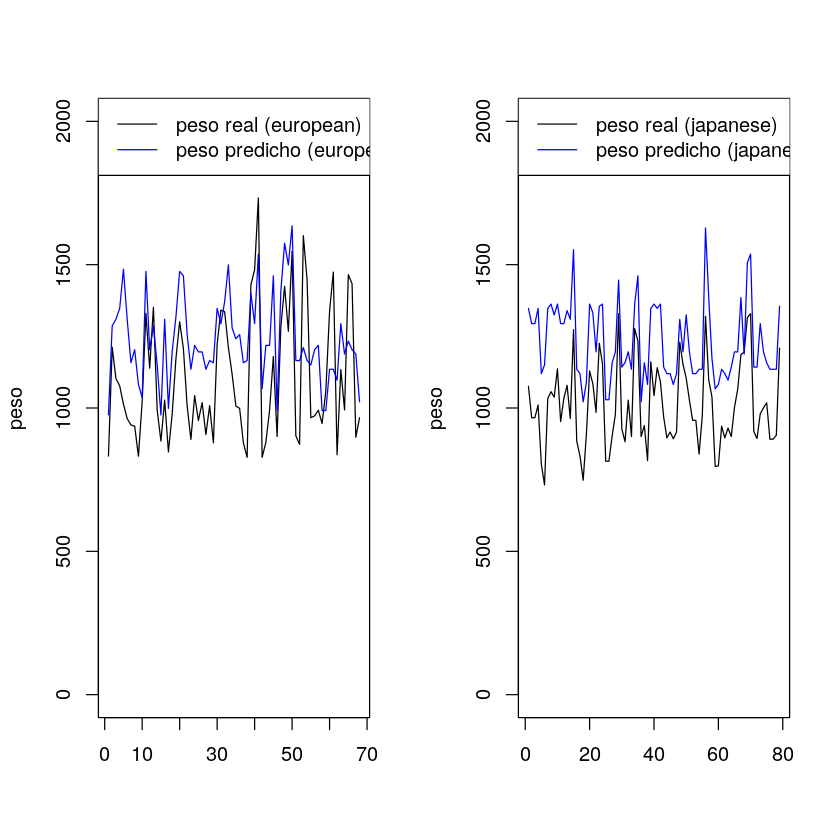

In [30]:
## gráfico
par(mfrow = c(1,2))

# coches europeos
plot(europe$weight, type = "l", lty = 1, ylim = c(0, 2000), 
     col = "black", xlab = "", ylab = "peso")  # pesos reales coches europeos
lines(ypred.europe, col = "blue", type = "l")  # pesos predichos coches europeos (en base a un modelo entrenado con coches americanos)
legend("topleft", c("peso real (european)", "peso predicho (european)"),
     col = c("black", "blue"), lty = 1)

# coches japoneses
plot(japan$weight, type = "l", lty = 1, ylim = c(0, 2000), 
     col = "black", xlab = "", ylab = "peso")  # pesos reales coches japoneses
lines(ypred.japan, col = "blue", type = "l") # pesos predichos coches japoneses (en base a un modelo entrenado con coches americanos)
legend("topleft", c("peso real (japanese)", "peso predicho (japanese)"),
     col = c("black", "blue"), lty = 1)

Se puede comprobar que el modelo entrenado con los coches americanos (con pesos muy altos) sobreestima los pesos de los coches europeos y japoneses.